In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from copy import deepcopy
import glob, sys

[sys.path.append(f) for f in glob.glob('../utils/*')]
from preprocess import *
from firingrate import raster2FR
from plotting_utils import *
from lineplots import plotsd
from stabilizer_utils import *
from recalibration_utils import *
from session_utils import *

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score


min_nblocks    = 3
max_ndays      = 1e99

fig_path       = 'C:/Users/ghwilson/Box/GuyWilson_Files/nonstationarities_project/paper_figures/figures/'
filelist       = glob.glob('D:/T5_ClosedLoop/new/*')
sessions_check = np.load('../utils/misc_data/OldSessions_check.npy', allow_pickle = True).item()
files          = get_Sessions(filelist, min_nblocks,  manually_remove = sessions_check['bad_days'])
pairs          = get_SessionPairs(files, max_ndays = max_ndays)
n_pairs        = len(pairs)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from CosineTuning import unit_vector, fitEncodingMatrix, angle_between
from sklearn.linear_model import Ridge

# general settings:
np.random.seed(42)
diffs           = list()
task            = None
train_size      = 0.67
sigma           = None


uniqueFiles     = np.unique(np.concatenate(pairs))
nUnique         = len(uniqueFiles)
dates           = list()
scores          = list()
weightsD        = list()
weightsE        = list()

angles          = np.zeros((n_pairs, 2, 2)) # pair, encoding/decoding weights, x/y velocity
diffs           = np.zeros((n_pairs))       # number of days separating sessions 

# First calculate encoding and decoding weights independently for each session:
for file in uniqueFiles:
    session = DataStruct(file, alignScreens = True)
    
    # obtain features and cursorError targets:
    train_x, test_x, train_y, test_y  = getTrainTest(session, train_size = train_size, sigma = 2, blocks = None, task = None, returnFlattened = True)    
    train_x, test_x   = get_BlockwiseMeanSubtracted(train_x, test_x, concatenate = True)
    train_y           = np.concatenate(train_y)
    test_y            = np.concatenate(test_y)
    score1            = traintest_DecoderSupervised([train_x], [test_x], [train_y], [test_y], meanRecal = False)[0][0]
    
    train_x, test_x, train_y, test_y  = getTrainTest(session, train_size = train_size, sigma = 2, blocks = None, task = None, returnFlattened = True)    
    train_x, test_x   = get_BlockwiseMeanSubtracted(train_x, test_x, concatenate = True)
    train_y           = np.concatenate(train_y)
    test_y            = np.concatenate(test_y)
    score2            = Ridge(alpha = 1e7).fit(train_x, train_y).score(test_x, test_y)
    
    scores.append([score1, score2])
    

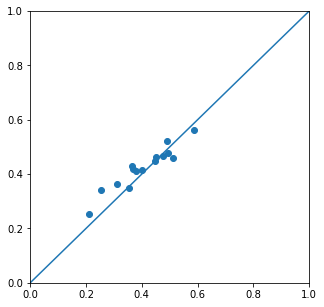

In [5]:
figSize(5, 5)
plt.scatter(np.vstack(scores)[:, 0], np.vstack(scores)[:, 1])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot([0, 1], [0, 1])

In [6]:
from CosineTuning import unit_vector, fitEncodingMatrix, angle_between

# general settings:
np.random.seed(42)
diffs           = list()
task            = None
train_size      = 0.67
sigma           = 2


uniqueFiles     = np.unique(np.concatenate(pairs))
nUnique         = len(uniqueFiles)
dates           = list()
scores          = list()
weightsD        = list()
weightsE        = list()

angles          = np.zeros((n_pairs, 2, 2)) # pair, encoding/decoding weights, x/y velocity
diffs           = np.zeros((n_pairs))       # number of days separating sessions 

# First calculate encoding and decoding weights independently for each session:
for file in uniqueFiles:
    session = DataStruct(file, alignScreens = True)
    
    # obtain features and cursorError targets:
    train_x, test_x, train_y, test_y  = getTrainTest(session, train_size = train_size, sigma = sigma, blocks = None, task = task, returnFlattened = True)    
    train_x, test_x   = get_BlockwiseMeanSubtracted(train_x, test_x, concatenate = True)
    train_y           = np.concatenate(train_y)
    test_y            = np.concatenate(test_y)
    #score, decoder    = traintest_DecoderSupervised([train_x], [test_x], [train_y], [test_y], meanRecal = False)
    decoder           = Ridge(alpha = 1e7).fit(train_x, train_y)
    score             = decoder.score(test_x, test_y)
    encoder           = fitEncodingMatrix(train_y, train_x, fitMean = False)
    
    dates.append(session.date)
    scores.append(score)
    weightsD.append(decoder)
    weightsE.append(encoder)
    
# now compare weight similarities across sessions: 
for i, (A_file, B_file) in enumerate(pairs):
    A_date   = A_file.split('t5.')[1].split('.mat')[0]
    B_date   = B_file.split('t5.')[1].split('.mat')[0]
    diffs[i] = daysBetween(A_date, B_date)

    A_ind  = np.where(np.in1d(dates, A_date))[0][0]
    B_ind  = np.where(np.in1d(dates, B_date))[0][0]

    for j in range(2):
        angles[i, 0, j]  = angle_between(weightsD[A_ind].coef_[j, :], weightsD[B_ind].coef_[j, :])
        angles[i, 1, j]  = angle_between(weightsE[A_ind][j, :], weightsE[B_ind][j, :])

    if (i + 1) % 200 == 0:
        print(i+ 1, '/', len(pairs))



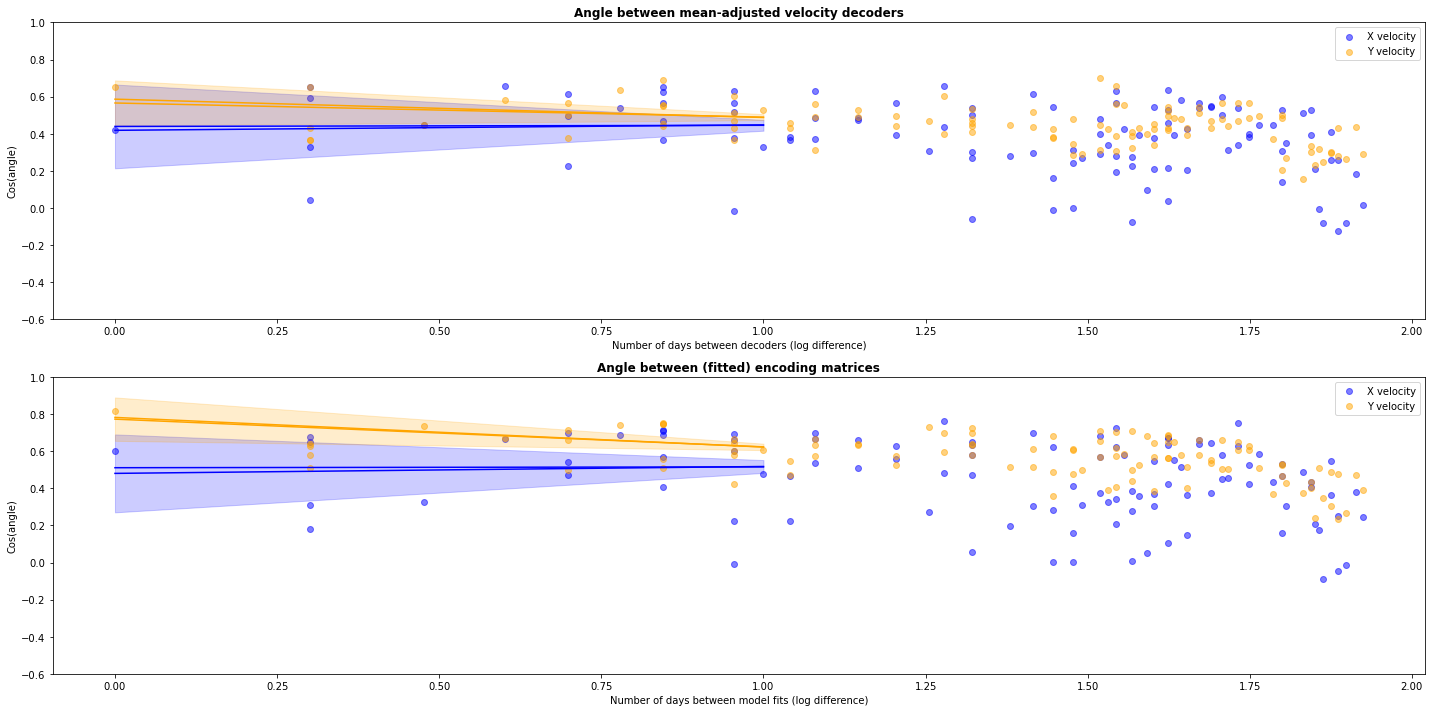

In [7]:
figSize(10, 20)

n_iters = 1000

#subselect = np.logical_and(scores[:, 0] > 0, scores[:, 1] > 0)
scores    = np.asarray(scores)
subselect = np.arange(scores.shape[0])
subselect = np.arange(n_pairs)
x         = np.log10(diffs[subselect])
colors    = ['b', 'orange']
labels    = ['X velocity', 'Y velocity']

# Decoders
plt.subplot(2, 1, 1)
for i in range(2):
    y = np.cos(angles[subselect, 0, i])
    plt.scatter(x, y, alpha = 0.5, color = colors[i], label = labels[i])
    
    poly = np.poly1d(np.polyfit(x, y, deg = 3))
    plt.plot(np.arange(max(x)), poly(np.arange(max(x))), color = colors[i])

    bootstrap_CI = np.zeros((len(np.arange(max(x))), n_iters))

    for j in range(n_iters):
        bs_inds = np.random.choice(len(x), len(x), replace = True)
        poly    = np.poly1d(np.polyfit(x[bs_inds], y[bs_inds], deg = 3))
        bootstrap_CI[:, j] = poly(np.arange(max(x)))

    plotsd(bootstrap_CI.T, time_bins= np.arange(max(x)), color = colors[i])
    
plt.xlabel('Number of days between decoders (log difference)')
plt.ylabel('Cos(angle)')
plt.title('Angle between mean-adjusted velocity decoders', fontweight = 'bold')
plt.ylim([-0.6, 1])
plt.legend()

# Encodings:
plt.subplot(2, 1, 2)
for i in range(2):
    y = np.cos(angles[subselect, 1, i])
    plt.scatter(x, y, alpha = 0.5, color = colors[i], label = labels[i])
    
    poly = np.poly1d(np.polyfit(x, y, deg = 3))
    plt.plot(np.arange(max(x)), poly(np.arange(max(x))), color = colors[i])

    bootstrap_CI = np.zeros((len(np.arange(max(x))), n_iters))

    for j in range(n_iters):
        bs_inds = np.random.choice(len(x), len(x), replace = True)
        poly    = np.poly1d(np.polyfit(x[bs_inds], y[bs_inds], deg = 3))
        bootstrap_CI[:, j] = poly(np.arange(max(x)))

    plotsd(bootstrap_CI.T, time_bins= np.arange(max(x)), color = colors[i])
    
plt.xlabel('Number of days between model fits (log difference)')
plt.ylabel('Cos(angle)')
plt.title('Angle between (fitted) encoding matrices', fontweight = 'bold')
plt.ylim([-0.6, 1])
plt.legend()

plt.tight_layout()

#plt.savefig(fig_path + 'SNR/T5_EncDec_Drift', format = 'pdf')

### Look at encoder drift model

Now we'll fit a linear model of our encoder drift across days with the formula:

$E' = \alpha E + \epsilon \ \ \ $     where $\epsilon \sim N(0, \sigma^{2}) $

This will help us determine plausible parameters for the closed-loop simulator by figuring out good values for the *shrinkage factor* $\alpha$ and noise model. Once we get the shrinkage factors for each pair of sessions, we can then fit some 
canonical shrinkage factor per day that helps compare these data across pairs (each pair may have e.g. 2 or 200 days apart). In this updated model, we have that:

$E^{(n)} = a^{n} E_{0} + \epsilon \ \ \ $ where $\epsilon \sim N(0, \sigma^{2} n * (\alpha^{n-1})^{2}) $

We can get this base shrinkage $\alpha$ value by performing linear regression on the observed shrinkages in log-space:

$\alpha_{x} \approx \hat{\alpha} = \exp(c \cdot x )$

$c = argmin_{a_{0}} ||\log(\alpha_{x}) - x * log(\alpha_{0}) ||^{2} $

Base alpha =  0.9255372577079332
Base alpha =  0.9429481788179632


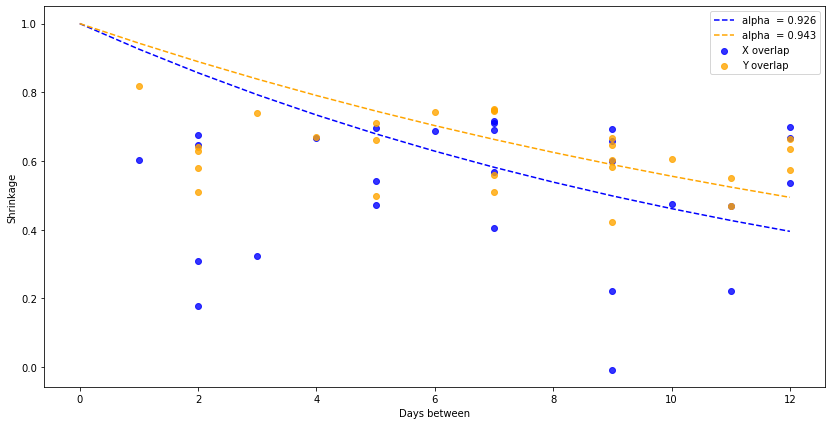

In [8]:
figSize(7, 14)
window = 14 # look at sessions up to two weeks apart
colors = ['b', 'orange']
labels = ['X overlap', 'Y overlap']


withinWindow      = np.where(diffs < window)[0]
withinDiffs       = diffs[withinWindow]

for i in range(2):
    withinShrinkages  = np.cos(angles[withinWindow, 1, i])
    x                 = np.arange(max(withinDiffs) + 1)
   # predx    = np.vstack([withinDiffs, np.ones(len(withinDiffs))]).T
   # mult, c  = np.linalg.lstsq(predx, np.log(withinShrinkages + 0.5)[:, np.newaxis], rcond = None)[0]
   # ypred    = np.exp((mult * x) + c) - 0.5

    predx = withinDiffs[withinShrinkages > 0, np.newaxis]
    mult  = np.linalg.lstsq(predx, np.log(withinShrinkages[withinShrinkages > 0])[:, np.newaxis], rcond = None)[0][0][0]
    ypred = np.exp(mult * x) 
    
    alpha    = np.exp(mult)
    print('Base alpha = ', alpha)

    plt.scatter(withinDiffs, withinShrinkages, alpha = 0.8, color = colors[i], label = labels[i])
    
    
    plt.plot(x, ypred, color = colors[i], linestyle = '--', label = 'alpha  = ' + str(np.round(alpha, 3)))


plt.xlabel('Days between')
plt.ylabel('Shrinkage')
plt.legend()